In [0]:
import sys
!apt install -y caffe-cuda
import caffe

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
path='/content/drive/My Drive/ICPR 2012 dataset/Testing/'

In [4]:
!ls '/content/drive/My Drive/ICPR 2012 dataset/Training'

A00_v2	A01_v2	A02_v2	A03_v2	A04_v2


In [0]:
import numpy as np
from skimage.color import rgb2hed
from skimage.measure import label, regionprops
from skimage.io import imread, imshow, imread_collection, concatenate_images
from PIL import Image
import os
import matplotlib.pyplot as plt
import cv2

image_paths=['A00_v2/A00_00','A00_v2/A00_08','A01_v2/A01_04','A01_v2/A01_06','A01_v2/A01_09','A02_v2/A02_00','A02_v2/A02_01','A02_v2/A02_03','A02_v2/A02_07','A03_v2/A03_00','A03_v2/A03_01','A03_v2/A03_04','A04_v2/A04_03','A04_v2/A04_07','A04_v2/A04_09']

X_train=[]
Y_train=[]
bb_train=[]

def crop(im,height,width,imgheight,imgwidth):
    for i in range(int(imgheight/height)):
        for j in range(int(imgwidth/width)):
            # print (i,j)
            box = (j*width, i*height, (j+1)*width, (i+1)*height)
            yield im.crop(box)


for k in range(len(image_paths)):

  image = Image.open(path+image_paths[k]+".bmp")
  imgwidth, imgheight = image.size
  height = int(imgheight/4)
  width =  int(imgwidth/4)
  start_num = 0
  for x,piece in enumerate(crop(image,height,width,imgheight,imgwidth),start_num):
      img=Image.new('RGB', (width,height), 255)
      img.paste(piece)
      X_train.append(np.array(img))
      img.save(path+'images/'+image_paths[k][7:]+'_'+str(x+1)+".bmp")
  
  height,width=image.size

  patch = np.full((height,width),255)

  f = open(path+image_paths[k]+".csv", "r")
  
  for line in f:
    lines=line.split()
    pixels=lines[0].split(",")
    
    for i in range(0,len(pixels),2):
      patch[int(pixels[i+1])][int(pixels[i])]=0
  
  imgwidth, imgheight = image.size
  height = int(imgheight/4)
  width =  int(imgwidth/4)
  for i in range(4):
    for j in range(4):
      Y_train.append(patch[i*width:(i+1)*width,j*height:(j+1)*height])
      mask_0 = np.invert(patch[i*width:(i+1)*width,j*height:(j+1)*height])
      lbl_0 = label(mask_0)
      props = regionprops(lbl_0)
      bb_train.append(props)
  
X_train=np.array(X_train)
Y_train=np.array(Y_train)
bb_train=np.array(bb_train)

(521, 521, 3)


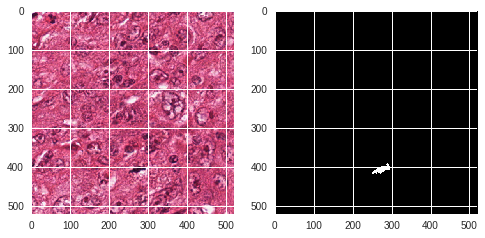

In [8]:
print(X_train[0].shape)
plt.subplot(1,2,1)
plt.imshow(X_train[14])
plt.subplot(1,2,2)
plt.imshow(Y_train[14])

(521, 521, 3)
(521, 521)
Found bbox (0, 0, 521, 521)
Found bbox (129, 206, 166, 235)
Found bbox (390, 311, 434, 343)


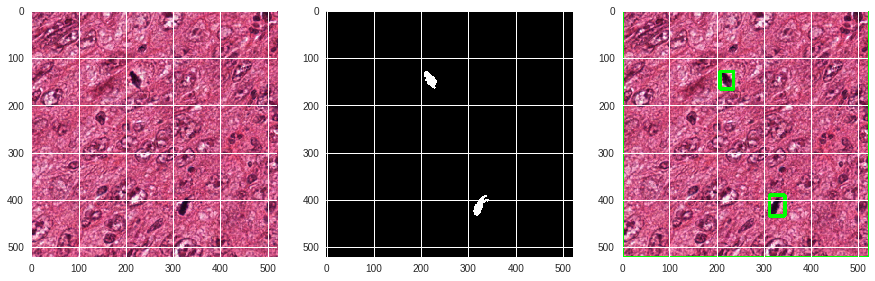

In [9]:
print(X_train[0].shape)
print(Y_train[0].shape)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5))
ax1.imshow(X_train[11,:,:,:])
ax2.imshow(Y_train[11])
img_1 = X_train[11,:,:,:].copy()
for prop in bb_train[11]:
    print('Found bbox', prop.bbox)
    cv2.rectangle(img_1, (prop.bbox[1], prop.bbox[0]), (prop.bbox[3], prop.bbox[2]), (0, 255, 0), 5)
ax3.imshow(img_1)

In [0]:
from __future__ import print_function

import os
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K

K.set_image_data_format('channels_last')

img_rows = 512
img_cols = 512

smooth = 1.


def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


def get_unet():
    inputs = Input((img_rows, img_cols, 3))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(2, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])

    return model


def preprocess(imgs):
    imgs_p = np.ndarray((imgs.shape[0], img_rows, img_cols,3), dtype=np.uint8)
    for i in range(imgs.shape[0]):
        imgs_p[i] = resize(imgs[i], (img_cols, img_rows,3), preserve_range=True)
    return imgs_p


def train_and_predict(batch_size):

    imgs_train=X_train[:int(.9*X_train.shape[0])]
    imgs_mask_train=Y_train[:int(.9*X_train.shape[0])]
    
    imgs_train = preprocess(imgs_train)
    imgs_mask_train = preprocess(imgs_mask_train)
    
    imgs_train = imgs_train.astype('float32')
    mean = np.mean(imgs_train)  # mean for data centering
    std = np.std(imgs_train)  # std for data normalization

    imgs_train -= mean
    imgs_train /= std

    imgs_mask_train = imgs_mask_train.astype('float32')
    imgs_mask_train /= 255.  # scale masks to [0, 1]

    model = get_unet()
    model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)

    print("Training....")
    model.fit(imgs_train, imgs_mask_train, batch_size=batch_size, nb_epoch=50, verbose=1, shuffle=True,
              validation_split=0.2,
              callbacks=[model_checkpoint])

    imgs_test = X_train[int(.9*X_train.shape[0]):]
    imgs_test = preprocess(imgs_test)

    imgs_test = imgs_test.astype('float32')
    imgs_test -= mean
    imgs_test /= std

    model.load_weights('weights.h5')
    print("Predicting....")
    imgs_mask_test = model.predict(imgs_test, verbose=1)
    np.save('imgs_mask_test.npy', imgs_mask_test)
    return imgs_mask_test



In [17]:
predicts = train_and_predict(batch_size=5)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Training....


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 172 samples, validate on 44 samples
Epoch 1/50


InvalidArgumentError: ignored

In [0]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (30, 10))
org=resize(X_train[14], (img_cols, img_rows), preserve_range=True)
ax1.imshow(org[:,:,0])
ax2.imshow(predicts[0,:,:,0])
truth=resize(Y_train[14], (img_cols, img_rows), preserve_range=True)
ax3.imshow(truth)